In [ ]:
## ---------- ##
# Environment #
## ---------- ##

import os
cwd = os.getcwd()

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import tensorflow as tf
import numpy as np

# SEED experiments are to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)  

# Access to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Image Segmentation ACRE
## Build dataset

In [ ]:
# ------------------ #
# ImageDataGenerator
# ------------------ #
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_data_gen = ImageDataGenerator()
mask_data_gen = ImageDataGenerator()

In [ ]:
from PIL import Image

class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None,validation_part=0.2,out_shape=[512,512],projects=['Weedelec','Pead','Roseau','Bipbip'],plants=['Haricot','Mais']):
    
    # ---------- #
    # Attributs  #
    # ---------- #

    self.png_or_jpg = []
    self.subset_filenames = []
    self.subset_direc = []

    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape
    
    for project in projects :
      for plant in plants :
        path = os.path.join(dataset_dir,project,plant)
        list_ = os.listdir(os.path.join(path,'Images')) 
        number_files = len(list_)
        training_num_max = int(number_files - int(number_files *  (1 - validation_part)))
        
        # ----- Training set  ----- #

        if which_subset == 'training':
          number_max = training_num_max
          for ii in range(0,number_max):
            self.subset_filenames.append(os.path.splitext(list_[ii])[0])
            self.subset_direc.append(path)

            if project!='Roseau': # Roseau has images and masks as png.
              self.png_or_jpg.append(1)
            else:
              self.png_or_jpg.append(0)

        # ----- Validation set  ----- #
              
        elif which_subset == 'validation':
          number_max = number_files - training_num_max
          for ii in range(number_files - 1, number_files - number_max, -1):
            self.subset_filenames.append(os.path.splitext(list_[ii])[0])
            self.subset_direc.append(path)
            if project!='Roseau':
              self.png_or_jpg.append(1)
            else:
              self.png_or_jpg.append(0)
            

  def __len__(self):
    return len(self.subset_filenames)

  
  def __getitem__(self, index):
    
    #Read files (image and target)
    curr_filename = self.subset_filenames[index]
    curr_dir = self.subset_direc[index]
    
    if self.png_or_jpg[index] != 0:
      img = Image.open(os.path.join(curr_dir, 'Images', curr_filename + '.jpg'))
    else:
      img = Image.open(os.path.join(curr_dir, 'Images', curr_filename + '.png'))
    
    mask = Image.open(os.path.join(curr_dir, 'Masks', curr_filename + '.png'))

    # Resize 
    img = img.resize(self.out_shape)
    mask = mask.resize(self.out_shape, resample=Image.NEAREST)

    mask_arr = np.array(mask)
    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [216, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2
    
    img_arr = np.array(img)
    mask_arr = new_mask_arr
    mask_arr = np.expand_dims(mask_arr, -1)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        
        # Perform data augmentation
        
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    img_arr=1./255*img_arr
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(255*img_arr)

    return img_arr, np.float32(out_mask)

In [ ]:
path = '/content/drive/MyDrive/Keras_Tutorial_4/Development_Dataset/Training/'
val_part = 0.2

dataset = CustomDataset(path, 'training', 
                        img_generator=img_data_gen, 
                        mask_generator=mask_data_gen,
                        preprocessing_function=None,
                        validation_part=val_part,
                        projects=['Weedelec','Pead','Roseau','Bipbip'],
                        plants=['Mais','Haricot'])
dataset_valid = CustomDataset(path, 'validation', 
                            preprocessing_function=None,
                            validation_part=val_part,
                            projects=['Roseau'],
                            plants=['Mais','Haricot'])


In [ ]:
img_h = 512#256
img_w = 512#256
bs = 5

train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
train_dataset = train_dataset.batch(bs)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w,1]))
valid_dataset = valid_dataset.batch(bs)

valid_dataset = valid_dataset.repeat()

In [ ]:
# ---------------------------- #
# Test of the dataset creation
# ---------------------------- #

import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 2)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(valid_dataset)

[0. 1. 2.]


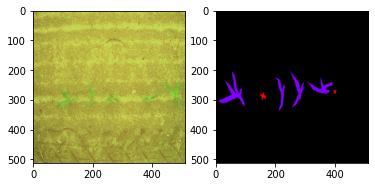

In [ ]:
fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[1]   # First element
augmented_img = 255*augmented_img  # denormalize

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

## Network for image classifaction
### Encoder -Decoder

In [ ]:
def create_model(start_f):
  input_shape = [img_h, img_w, 3]
  inputs = tf.keras.Input(shape=(img_h, img_w, 3))
  x_1_1 = tf.keras.layers.Conv2D(filters = start_f, 
                                kernel_size = (2,2),
                                strides=(1, 1),
                                padding='same')(inputs)
  x_1_1 = tf.keras.layers.Conv2D(filters = start_f, 
                                kernel_size = (2,2),
                                strides=(1, 1),
                                padding='same')(x_1_1)                              
  x_1_2 = tf.keras.layers.Conv2D(filters = start_f, 
                                kernel_size = (3,3),
                                strides=(1, 1),
                                padding='same')(inputs)
  x_1_2 = tf.keras.layers.Conv2D(filters = start_f, 
                                kernel_size = (3,3),
                                strides=(1, 1),
                                padding='same')(x_1_2)
  x_1 = tf.keras.layers.Average()([x_1_1, x_1_2])
  input_shape = None


  start_f *= 2
  x_1 = tf.keras.layers.BatchNormalization(axis=-1)(x_1)
  x_1  = tf.keras.layers.Activation('relu')(x_1)
  x_2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x_1)
  x_2_1 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(2, 2),
                      strides = (1,1),
                      padding = 'same')(x_2)
  x_2_1 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(2, 2),
                      strides = (1,1),
                      padding = 'same')(x_2_1)
 
  x_2_2 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(3, 3),
                      strides = (1,1),
                      padding = 'same')(x_2)
  x_2_2 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(2, 2),
                      strides = (1,1),
                      padding = 'same')(x_2_2)

  x_2 = tf.keras.layers.Average()([x_2_1, x_2_2])
  x_2 = tf.keras.layers.BatchNormalization(axis=-1)(x_2)
  x_2 = tf.keras.layers.Activation('relu')(x_2)
  x_3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x_2)



  start_f *= 2
  x_3_1 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(2, 2),
                      strides = (1,1),
                      padding = 'same')(x_3)
  x_3_1 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(2, 2),
                      strides = (1,1),
                      padding = 'same')(x_3_1)
  x_3_2 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(3, 3),
                      strides = (1,1),
                      padding = 'same')(x_3)
  x_3_2 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(3, 3),
                      strides = (1,1),
                      padding = 'same')(x_3_2)

  x_3 = tf.keras.layers.Average()([x_3_1, x_3_1])
  x_3 = tf.keras.layers.BatchNormalization(axis=-1)(x_3)
  x_3 = tf.keras.layers.Activation('relu')(x_3)
  x_4 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x_3)


  start_f *= 2
  x_4_1 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(2, 2),
                      strides = (1,1),
                      padding = 'same')(x_4)
  x_4_1 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(2, 2),
                      strides = (1,1),
                      padding = 'same')(x_4_1)
  x_4_2 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(3, 3),
                      strides = (1,1),
                      padding = 'same')(x_4)
  x_4_2 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(3, 3),
                      strides = (1,1),
                      padding = 'same')(x_4_2)

  x_4 = tf.keras.layers.Average()([x_4_1, x_4_2])
  x_4 = tf.keras.layers.BatchNormalization(axis=-1)(x_4)
  x_4 = tf.keras.layers.Activation('relu')(x_4)
  x_5 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x_4)

  start_f *= 2
  x_5_1 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(2, 2),
                      strides = (1,1),
                      padding = 'same')(x_5)
  x_5_1 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(2, 2),
                      strides = (1,1),
                      padding = 'same')(x_5_1)
  x_5_2 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(3, 3),
                      strides = (1,1),
                      padding = 'same')(x_5)
  x_5_2 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(3, 3),
                      strides = (1,1),
                      padding = 'same')(x_5_2)
 
  x_5 = tf.keras.layers.Average()([x_5_1, x_5_2])
  x_5 = tf.keras.layers.BatchNormalization(axis=-1)(x_5)
  x_5 = tf.keras.layers.Activation('relu')(x_5)



  #MIDDLE BLOCK
  m = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(3, 3),
                      strides = (1,1),
                      padding = 'same')(x_5)
  m = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(3, 3),
                      strides = (1,1),
                      padding = 'same')(m)
  
  m = tf.keras.layers.BatchNormalization(axis=-1)(m)
  m = tf.keras.layers.Activation('relu')(m)

  #DECODER
  start_f = start_f // 2
  y_1_1 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(2,2), strides=(2, 2), padding='same')(m)
  y_1_1 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(2,2), strides=(1, 1), padding='same')(y_1_1)
  y_1_2 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(3,3), strides=(2, 2), padding='same')(m)
  y_1_2 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(3,3), strides=(1,1), padding='same')(y_1_2)
  y_1 = tf.keras.layers.Average()([y_1_1, y_1_2])
  y_1 = tf.keras.layers.ReLU()(y_1)
  y_1 = tf.keras.layers.Add()([y_1,x_4])

  start_f = start_f // 2
  y_2_1 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(2,2), strides=(2, 2), padding='same')(y_1)
  y_2_1 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(2,2), strides=(1, 1), padding='same')(y_2_1)
  y_2_2 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(3,3), strides=(2, 2), padding='same')(y_1)
  y_2_2 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(3,3), strides=(1, 1), padding='same')(y_2_2)
  y_2 = tf.keras.layers.Average()([y_2_1, y_2_2])
  y_2 = tf.keras.layers.ReLU()(y_2)
  y_2 = tf.keras.layers.Add()([y_2,x_3])


  start_f = start_f // 2
  y_3_1 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(2,2), strides=(2, 2), padding='same')(y_2)
  y_3_1 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(2,2), strides=(1, 1), padding='same')(y_3_1)
  y_3_2 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(3,3), strides=(2, 2), padding='same')(y_2)
  y_3_2 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(3,3), strides=(1, 1), padding='same')(y_3_2)
  y_3 = tf.keras.layers.Average()([y_3_1, y_3_2])
  y_3 = tf.keras.layers.ReLU()(y_3)
  y_3 = tf.keras.layers.Add()([y_3,x_2])

  start_f = start_f // 2
  y_4_1 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(2,2), strides=(2, 2), padding='same')(y_3)
  y_4_1 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(2,2), strides=(1, 1), padding='same')(y_4_1)
  y_4_2 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(3,3), strides=(2, 2), padding='same')(y_3)
  y_4_2 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(3,3), strides=(1,1), padding='same')(y_4_2)
  y_4 = tf.keras.layers.Average()([y_4_1, y_4_2])
  y_4 = tf.keras.layers.ReLU()(y_4)
  y_4 = tf.keras.layers.Add()([y_4,x_1])
  y_4 = tf.keras.layers.Dropout(0.4, seed=SEED)(y_4)


  
  last = tf.keras.layers.Conv2D(filters=3,
                                kernel_size=(1, 1),
                                strides=(1, 1),
                                padding='same',
                                activation='softmax')(y_4)
  model_1 = tf.keras.Model(inputs=inputs, outputs=last)
  print("first model summary")
  model_1.summary()

  return model_1

In [ ]:
model=create_model(start_f=50)

# Model summary
model.summary()

# Weights summary
# model.weights

first model summary
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 50) 650         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 50) 1400        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 50) 10050       conv2d[0][0]                     
__________________________________________________________________________

## Prepare the model for training

In [ ]:
# ---------------------------- #
#    Optimization parameters   #
# ---------------------------- #

# Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# Learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)


# Metric for image segmentation 

def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3): # exclude the background class 0
    
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# ------------------- #
#  Validation metrics #
# ------------------- #

metrics = [ meanIoU,'accuracy']

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Training with callbacks

In [ ]:
callbacks = []

early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    callbacks.append(es_callback)


history=model.fit(x=train_dataset,
          epochs=15,  
          steps_per_epoch=500,
          validation_data=valid_dataset,
          validation_steps=150, 
          callbacks=callbacks)

Epoch 1/15
500/500 [==============================] - 1686s 3s/step - loss: 0.2821 - meanIoU: 0.2231 - accuracy: 0.8989 - val_loss: 0.4728 - val_meanIoU: 0.0242 - val_accuracy: 0.9110
Epoch 2/15
500/500 [==============================] - 1479s 3s/step - loss: 0.0819 - meanIoU: 0.3467 - accuracy: 0.9731 - val_loss: 0.3002 - val_meanIoU: 0.1274 - val_accuracy: 0.9203
Epoch 3/15
500/500 [==============================] - 1467s 3s/step - loss: 0.0714 - meanIoU: 0.4274 - accuracy: 0.9752 - val_loss: 0.3352 - val_meanIoU: 0.2284 - val_accuracy: 0.9314
Epoch 4/15
500/500 [==============================] - 1465s 3s/step - loss: 0.0597 - meanIoU: 0.5288 - accuracy: 0.9787 - val_loss: 0.2068 - val_meanIoU: 0.3027 - val_accuracy: 0.9393
Epoch 5/15
500/500 [==============================] - 1477s 3s/step - loss: 0.0529 - meanIoU: 0.5688 - accuracy: 0.9805 - val_loss: 0.3408 - val_meanIoU: 0.1661 - val_accuracy: 0.9291
Epoch 6/15
500/500 [==============================] - 1451s 3s/step - loss: 0.04

In [ ]:
#------------------------------
#       MODEL SAVING
#------------------------------

out = '/content/drive/My Drive/'



model_name = 'Roseau_specific_Newsize_Newval'

model.save(out + '/' + model_name  + '.h5')
model.save_weights(out + '/weights_' + model_name)

In [ ]:
# ---------------------------- #
#    Optimization parameters   #
# ---------------------------- #

# Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# Learning rate
lr = 1e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)


# Metric for image segmentation 

def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3): # exclude the background class 0
    
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# ------------------- #
#  Validation metrics #
# ------------------- #

metrics = [ meanIoU,'accuracy']

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
callbacks = []

early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    callbacks.append(es_callback)


history=model.fit(x=train_dataset,
          epochs=10,  
          steps_per_epoch=500,
          validation_data=valid_dataset,
          validation_steps=100, 
          callbacks=callbacks)

Epoch 1/10
500/500 [==============================] - 1461s 3s/step - loss: 0.0310 - meanIoU: 0.7414 - accuracy: 0.9871 - val_loss: 0.3106 - val_meanIoU: 0.3373 - val_accuracy: 0.9428
Epoch 2/10
500/500 [==============================] - 1440s 3s/step - loss: 0.0273 - meanIoU: 0.7723 - accuracy: 0.9886 - val_loss: 0.3223 - val_meanIoU: 0.3485 - val_accuracy: 0.9408
Epoch 3/10
500/500 [==============================] - 1429s 3s/step - loss: 0.0274 - meanIoU: 0.7756 - accuracy: 0.9886 - val_loss: 0.3885 - val_meanIoU: 0.3338 - val_accuracy: 0.9414
Epoch 4/10
500/500 [==============================] - 1428s 3s/step - loss: 0.0245 - meanIoU: 0.7943 - accuracy: 0.9897 - val_loss: 0.4057 - val_meanIoU: 0.3237 - val_accuracy: 0.9412
Epoch 5/10
500/500 [==============================] - 1434s 3s/step - loss: 0.0230 - meanIoU: 0.8014 - accuracy: 0.9903 - val_loss: 0.4765 - val_meanIoU: 0.2818 - val_accuracy: 0.9373
Epoch 6/10
500/500 [==============================] - 1425s 3s/step - loss: 0.02

In [ ]:
#------------------------------
#       MODEL SAVING
#------------------------------

out = '/content/drive/My Drive/'


model_name = 'Roseau_specific_2_newval_2'

model.save(out + '/' + model_name + '.h5')
model.save_weights(out + '/weights_' + model_name )

# Test model
### Results on validation 
### Plot accuracy, loss, meanIoU
### Submission

## Compute prediction

In [ ]:
path = '/content/drive/MyDrive/Keras_Tutorial_4/fourth_custom_network_Dec21_14-17-24.h5'
model = tf.keras.models.load_model(path,compile=False)

In [ ]:
img_h =512# 512
img_w =512# 512

from PIL import Image

class CustomDataSol(tf.keras.utils.Sequence):

  def __init__(self, dataset_dir, img_generator=None,
               preprocessing_function=None, out_shape=[512, 512],projects=['Weedelec','Pead','Roseau','Bipbip'],plants=['Haricot','Mais']):

    self.subset_filenames = []
    self.subset_direc = []
    self.projects = []
    self.plants = []
    self.dataset_dir = dataset_dir
    self.img_generator = img_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

    for project in projects :
      for plant in plants :
        path=os.path.join(dataset_dir,project,plant)
        list = os.listdir(os.path.join(path,'Images'))
        number_files = len(list)
        for ii in range(0,number_files):
            self.subset_filenames.append(os.path.splitext(list[ii])[0])
            self.subset_direc.append(path)
            self.projects.append(project)
            self.plants.append(plant)
    
  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    curr_dir = self.subset_direc[index]
    curr_project = self.projects[index]
    if curr_project == 'Roseau' :
      img = Image.open(os.path.join(curr_dir, 'Images', curr_filename + '.png'))
    else :
      img = Image.open(os.path.join(curr_dir, 'Images', curr_filename + '.jpg'))

    # Resize image 
    img = img.resize(self.out_shape)
    img_arr = np.array(img)
    
    img_arr=img_arr
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(255*img_arr)

    return img_arr

################################################################################
 # Encode array (start kit)

def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


################################################################################

path_test = '/content/drive/My Drive/Keras_Tutorial_4/Development_Dataset/Test_Dev/'
test_set=CustomDataSol(path_test, 
                        img_generator=None,
                        projects=['Weedelec','Pead','Roseau','Bipbip'],
                        plants=['Mais','Haricot'])
test_dataset = tf.data.Dataset.from_generator(lambda: test_set,
                                               output_types= tf.float32,
                                               output_shapes=[img_h, img_w, 3])

test_dataset = test_dataset.batch(1)
iterator = iter(test_dataset)
test_set.__len__()

120

In [ ]:
import time
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

iterator = iter(test_dataset)

(1, 512, 512, 3)

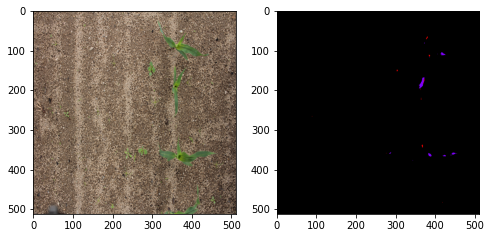

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
fig.show()
image = next(iterator)

image = image[0]
#target = target[0, ..., 0]


out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

# Get predicted class as the index corresponding to the maximum value in the vector probability
# predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
# predicted_class = predicted_class[0, ..., 0]
predicted_class = tf.argmax(out_sigmoid, -1)

out_sigmoid.shape

predicted_class = predicted_class[0, ...]

# Assign colors (just for visualization)
#target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([image.shape[0], image.shape[1], 3])

#target_img[np.where(target == 0)] = [0, 0, 0]
#for i in range(1, 3):
  #target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
for i in range(1, 3):
  prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(image))
#ax[1].imshow(np.uint8(target_img))
ax[1].imshow(np.uint8(prediction_img))

fig.canvas.draw()
time.sleep(1)

dict_keys(['loss', 'meanIoU', 'accuracy', 'val_loss', 'val_meanIoU', 'val_accuracy'])


Text(0.5, 1.0, 'model accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

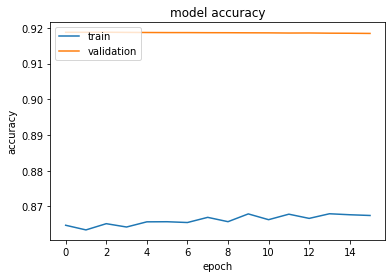

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

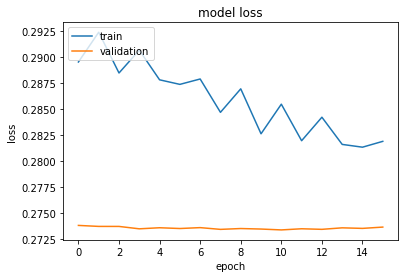

Text(0.5, 1.0, 'model meanIoU')

Text(0, 0.5, 'meanIoU')

Text(0.5, 0, 'epoch')

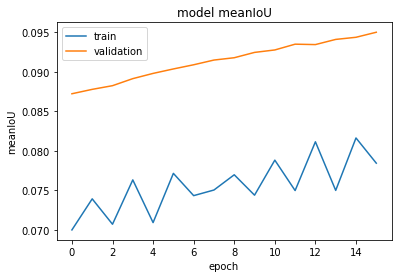

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for meanIoU
plt.plot(history.history['meanIoU'])
plt.plot(history.history['val_meanIoU'])
plt.title('model meanIoU')
plt.ylabel('meanIoU')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
from PIL import Image

class CustomDataSol(tf.keras.utils.Sequence):

  def __init__(self, dataset_dir, img_generator=None,
               preprocessing_function=None, out_shape=[512, 384],projects=['Weedelec','Pead','Roseau','Bipbip'],plants=['Haricot','Mais']):

    self.subset_filenames = []
    self.subset_direc = []
    self.projects = []
    self.plants = []
    self.dataset_dir = dataset_dir
    self.img_generator = img_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

    for project in projects :
      for plant in plants :
        path=os.path.join(dataset_dir,project,plant)
        list = os.listdir(os.path.join(path,'Images'))
        number_files = len(list)
        for ii in range(0,number_files):
            self.subset_filenames.append(os.path.splitext(list[ii])[0])
            self.subset_direc.append(path)
            self.projects.append(project)
            self.plants.append(plant)
    
  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    curr_dir = self.subset_direc[index]
    curr_project = self.projects[index]
    if curr_project == 'Roseau' :
      img = Image.open(os.path.join(curr_dir, 'Images', curr_filename + '.png'))
    else :
      img = Image.open(os.path.join(curr_dir, 'Images', curr_filename + '.jpg'))

    # Resize image 
    img = img.resize(self.out_shape)
    img_arr = np.array(img)
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(255*img_arr)

    return img_arr

################################################################################
 # Encode array (start kit)

def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


################################################################################

path_test = '/content/drive/My Drive/Keras_Tutorial_4/Development_Dataset/Test_Dev/'
test_set=CustomDataSol(path_test, 
                        img_generator=None,
                        projects=['Weedelec','Pead','Roseau','Bipbip'],
                        plants=['Mais','Haricot'])
test_dataset = tf.data.Dataset.from_generator(lambda: test_set,
                                               output_types= tf.float32,
                                               output_shapes=[img_h, img_w, 3])

test_dataset = test_dataset.batch(1)
iterator = iter(test_dataset)
#test_set.__len__()

submission_dict = {}
SIZE=[[1536,2048],[2464,3280],[819,1228],[3456,5184]]
for index in range(0,test_set.__len__()):#test_set.__len__()
      image = next(iterator)
      if test_set.projects[index]=='Bipbip':
        size_im=SIZE[0]
      elif test_set.projects[index]=='Pead':
        size_im=SIZE[1]
      elif test_set.projects[index]=='Roseau':
        size_im=SIZE[2]
      else:
        size_im=SIZE[3]
      img_name = os.path.splitext(test_set.subset_filenames[index])[0]
      submission_dict[img_name] = {}
      mask_arr =  model.predict(image)
      mask_arr = tf.image.resize(mask_arr, size_im, method='nearest')
      #mask_arr.size
      predicted_class = tf.argmax(mask_arr, -1)
      predicted_class = predicted_class[0, ...]
      prediction_img = np.zeros([size_im[0], size_im[1]]) # Here was the problem
      #prediction_img2 = np.zeros([size_im[0], size_im[1], 3])
  
      prediction_img[np.where(predicted_class == 0)] = 0
      #prediction_img2[np.where(predicted_class == 0)] = [0, 0, 0]
      for i in range(1, 3):
        prediction_img[np.where(predicted_class == i)] = i
        #prediction_img2[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255
      #fig, ax = plt.subplots(1, 2, figsize=(10, 10))
      #fig.show() 
      #print(np.uint8(prediction_img2).size)   
      #ax[0].imshow(np.uint8(prediction_img2))
      #ax[1].imshow(np.uint8(image[0]))
      #fig.canvas.draw()
      #time.sleep(1)

      submission_dict[img_name]['shape'] = size_im
      submission_dict[img_name]['team'] = test_set.projects[index]
      submission_dict[img_name]['crop'] = test_set.plants[index]
      submission_dict[img_name]['segmentation'] = {}
    
    # crop
      rle_encoded_crop = rle_encode(prediction_img == 1)
    # weed
      rle_encoded_weed = rle_encode(prediction_img == 2)

      submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
      submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed
#print(submission_dict)

import json
with open('/content/drive/My Drive/submission32.json', 'w') as file:
      json.dump(submission_dict, file)

120

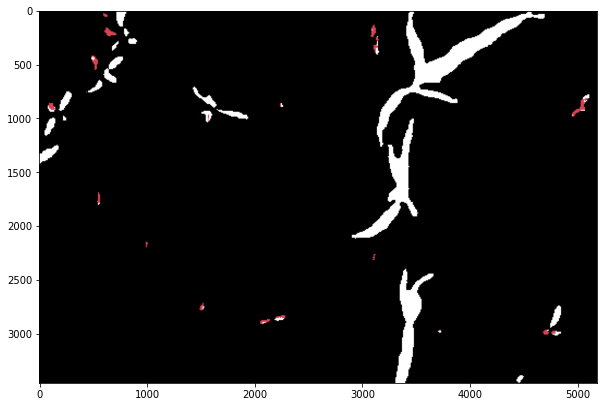

In [ ]:
iterator = iter(test_dataset)
img_name = os.path.splitext(test_set.subset_filenames[index])[0]
img_shape = submission_dict[img_name]['shape']

rle_encoded_crop = submission_dict[img_name]['segmentation']['crop']
rle_encoded_weed = submission_dict[img_name]['segmentation']['weed']

def rle_decode(rle, shape):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)
    # Reconstruct crop and weed binary masks
crop_mask = rle_decode(rle_encoded_crop, shape=img_shape)
weed_mask = rle_decode(rle_encoded_weed, shape=img_shape)

    # Reconstruct original mask
    # weed_mask * 2 allows to convert ones into target 2 (weed label)
reconstructed_mask = crop_mask + (weed_mask * 2)




    # Just for visualisation purposes, save RGB reconstructed mask
    # Use again the dictionary in 'RGBtoTarget.txt'.
reconstructed_rgb_arr = np.zeros(shape=img_shape + [3])
reconstructed_rgb_arr[reconstructed_mask == 1] = [255, 255, 255]
reconstructed_rgb_arr[reconstructed_mask == 2] = [216, 67, 82]
reconstructed_rgb_img = Image.fromarray(np.uint8(reconstructed_rgb_arr))

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
fig.show() 
ax.imshow(np.uint8(reconstructed_rgb_arr))      
fig.canvas.draw()
    

In [ ]:
from PIL import Image

class CustomDataSol(tf.keras.utils.Sequence):

  def __init__(self, dataset_dir, img_generator=None,
               preprocessing_function=None, out_shape=[256, 256],projects=['Weedelec','Pead','Roseau','Bipbip'],plants=['Haricot','Mais']):

    subset_filenames = []
    subset_direc = []
    name_project = []
    self.is_haricot_or_mais = []
    for project in projects :
      for plant in plants :
        path=os.path.join(dataset_dir,project,plant)
        list = os.listdir(os.path.join(path,'Images')) # dir is your directory path
        number_files = len(list)
        for ii in range(0,number_files):
          if plant == 'Haricot':
            self.is_haricot_or_mais.append(1)
          else:
            self.is_haricot_or_mais.append(0)
          subset_filenames.append(os.path.splitext(list[ii])[0])
          subset_direc.append(path)
          name_project.append(project)

    self.dataset_dir = dataset_dir
    self.projects = name_project
    self.subset_direc = subset_direc
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def get_plant_indexes(self):
    return self.is_haricot_or_mais

  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    curr_dir = self.subset_direc[index]
    curr_project = self.projects[index]
    if curr_project == 'Roseau' :
      img = Image.open(os.path.join(curr_dir, 'Images', curr_filename + '.png'))
    else :
      img = Image.open(os.path.join(curr_dir, 'Images', curr_filename + '.jpg'))

    # Resize image 
    img = img.resize(self.out_shape)
    img_arr = np.array(img)
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr
def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
test_set=CustomDataSol('/content/drive/My Drive/Keras_Tutorial_4/Development_Dataset/Test_Dev/', 
                        img_generator=img_data_gen,
                        projects=['Weedelec','Pead','Roseau','Bipbip'],
                        plants=['Haricot', 'Mais'])
test_dataset = tf.data.Dataset.from_generator(lambda: test_set,
                                               output_types= tf.float32,
                                               output_shapes=[img_h, img_w, 3])

test_dataset = test_dataset.batch(1)
iterator = iter(test_dataset)
test_set.__len__()
    
submission_dict = {}
for index in range(0,test_set.__len__()):
  image = next(iterator)
  img_name = os.path.splitext(test_set.subset_filenames[index])[0]
  submission_dict[img_name] = {}
      

# load mask <- HERE you should have your segmentation model instead
  mask_arr =  model.predict(image)
  mask_arr = tf.image.resize(mask_arr,  (1536, 2048), method='nearest')
  mask_arr.size
  predicted_class = tf.argmax(mask_arr, -1)
  predicted_class = predicted_class[0, ...]
      
  prediction_img = np.zeros([1536, 2048, 3])
  prediction_img[np.where(predicted_class == 0)] = 0
  for i in range(1, 3):
    prediction_img[np.where(predicted_class == i)] = i
  submission_dict[img_name]['shape'] = mask_arr.numpy().shape
  submission_dict[img_name]['team'] = test_set.projects[index]
  if test_set.get_plant_indexes()[index] == 0:
    submission_dict[img_name]['crop'] = 'Mais'
  else:
    submission_dict[img_name]['crop'] = 'Haricot'
  submission_dict[img_name]['segmentation'] = {}

    
    

  # RLE encoding
  # crop
  rle_encoded_crop = rle_encode(prediction_img == 1)
  # weed
  rle_encoded_weed = rle_encode(prediction_img == 2)

  submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
  submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed


#print(submission_dict)

  # Please notice that in this example we have a single prediction.
  # For the competition you have to provide segmentation for each of
  # the test images.

# Finally, save the results into the submission.json file
import json
with open('/content/drive/My Drive/submission12.json', 'w') as file:
        json.dump(submission_dict, file)

120